In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
imNum = 20
impath = 'peak'
#switching latex fonts
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})
# plt.rcParams.update({
#     "text.usetex": False,
#     "font.family": 'fantasy',
#     "font.fantasy": ['Arial', 'Times New Roman', 'Tahoma']})
plt.rcParams.update({
    "figure.figsize": (16, 10)
})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    if error == np.inf:
        return int(value)
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(X, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

In [3]:
df = pd.read_excel("table.xlsx", "Лист1")
df.head()

,N,med,dur,alu
0,0,0.0,0,0.0
1,1,3250.0,4131,4260.0
2,2,6474.0,8302,NaN
3,3,NaN,12427,NaN
4,4,NaN,16570,NaN


In [4]:
N = df['N']
y1 = df['med'].dropna()
y2 = df['dur'].dropna()
y3 = df['alu'].dropna()

In [5]:
from matplotlib import rc
rc('font',**{'family':'serif'})
rc('text', usetex=True)
# rc('text.latex',unicode=True)
rc('text.latex',preamble=r'')
rc('text.latex',preamble=r'''\usepackage[utf8]{inputenc}
\usepackage[russian]{babel}
\usepackage{amsmath}
\usepackage{mathtext}''')
# rc('text.latex',preamble=r'\usepackage[warn]{mathtext}')


3237.000000811824 +- 7.505541009511617
4.333327400193639 +- 9.689610503868478
4143.5999764965 +- 3.6717721220323294
-1.1999827275017196 +- 8.993791355177537
4260.000001266593 +- inf
2.7625979574699006e-18 +- inf


/home/amir/anaconda3/envs/LabDataEnv/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


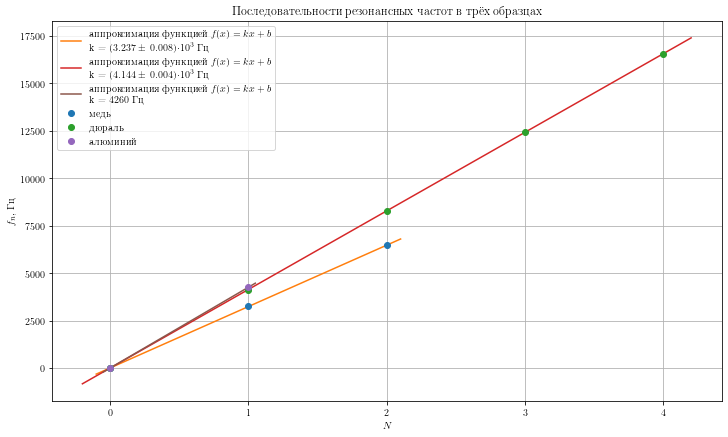

In [6]:
#xi square approximation with Y-errors
%matplotlib inline
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название осей с размерностями, 
нагвание графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = False   # рисовать ли область ошибки аппроксимации
par_names = r'''
k, Гц
'''
# function to approximate
fun_name = "$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

from scipy.optimize import curve_fit
x = N[:len(y1)]
popt, pcov = curve_fit(f, x, y1)
err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)

approx_label = f"аппроксимация функцией {fun_name}"
par_names = [x.split(', ') for x in par_names.strip().split("\n")]
for i in range(len(par_names)):
    name, units = par_names[i]
    tup = err_pres_formatter(popt[i], err[i])
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    
plt.figure(figsize=(12, 7))
plt.errorbar(x, y1, fmt="o", label="медь", capsize=4, ms=6)
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), label=approx_label)
#2
x = N[:len(y2)]
popt, pcov = curve_fit(f, x, y2)
err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)

approx_label = f"аппроксимация функцией {fun_name}"
for i in range(len(par_names)):
    name, units = par_names[i]
    tup = err_pres_formatter(popt[i], err[i])
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    

plt.errorbar(x, y2, fmt="o", label="дюраль", capsize=4, ms=6)
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), label=approx_label)
#3
x = N[:len(y3)]
popt, pcov = curve_fit(f, x, y3)
err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)

approx_label = f"аппроксимация функцией {fun_name}"
for i in range(len(par_names)):
    name, units = par_names[i]
    tup = err_pres_formatter(popt[i], err[i])
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    

plt.errorbar(x, y3, fmt="o", label="алюминий", capsize=4, ms=6)
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), label=approx_label)




plt.grid(True)
plt.xlabel(r"$N$")
plt.ylabel(r"$f_n$, Гц")
plt.title(r"Последовательности резонансных частот в трёх образцах")
plt.legend()

plt.savefig(f"result{imNum}.png", dpi=300)
imNum+=1

In [7]:
X

array([-0.05      , -0.02755102, -0.00510204,  0.01734694,  0.03979592,
        0.0622449 ,  0.08469388,  0.10714286,  0.12959184,  0.15204082,
        0.1744898 ,  0.19693878,  0.21938776,  0.24183673,  0.26428571,
        0.28673469,  0.30918367,  0.33163265,  0.35408163,  0.37653061,
        0.39897959,  0.42142857,  0.44387755,  0.46632653,  0.48877551,
        0.51122449,  0.53367347,  0.55612245,  0.57857143,  0.60102041,
        0.62346939,  0.64591837,  0.66836735,  0.69081633,  0.71326531,
        0.73571429,  0.75816327,  0.78061224,  0.80306122,  0.8255102 ,
        0.84795918,  0.87040816,  0.89285714,  0.91530612,  0.9377551 ,
        0.96020408,  0.98265306,  1.00510204,  1.02755102,  1.05      ])

In [8]:
a = \
'''8296 4
8288 3
8282 2.4
8275 1.8
8264 1.2
8306 3.4
8314 2.4
8319 1.8''' 

data = np.array([x.split() for x in a.split('\n')], dtype=float)
data

array([[8.296e+03, 4.000e+00],
       [8.288e+03, 3.000e+00],
       [8.282e+03, 2.400e+00],
       [8.275e+03, 1.800e+00],
       [8.264e+03, 1.200e+00],
       [8.306e+03, 3.400e+00],
       [8.314e+03, 2.400e+00],
       [8.319e+03, 1.800e+00]])

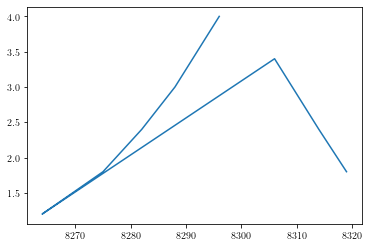

In [9]:
plt.plot(data[:, 0], data[:, 1])

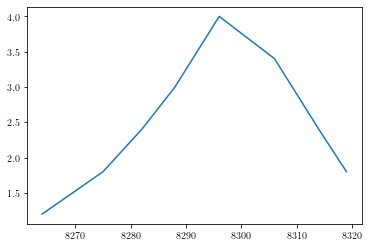

In [10]:
data = np.array(sorted(data, key=lambda x: x[0]))
plt.plot(data[:, 0], data[:, 1])

19094.159192057476 +- 589.4974957064422
1320.699146584097 +- 0.05913443353163572
-1.7600686785846835 +- 0.08284311784251787


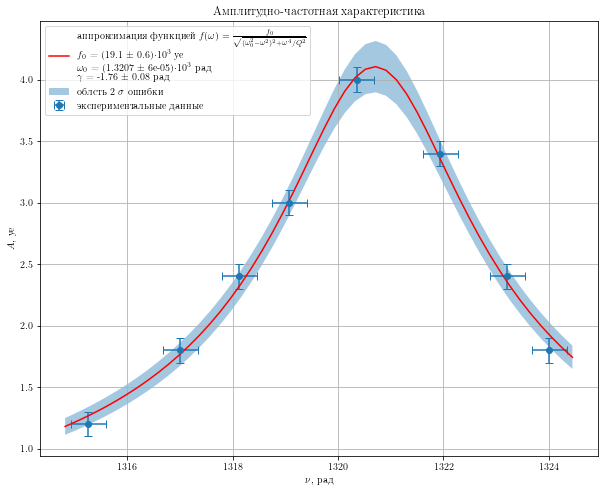

In [17]:
#xi square approximation with Y-errors
%matplotlib inline
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название осей с размерностями, 
нагвание графика, 
название функции ,
набор параметров с размерностями через запятую '''

x = data[:,0]/2/np.pi
y = data[:,1]
yerr = np.ones_like(y)*0.1
xerr = np.ones_like(y)*1/3
visApproxError = True   # рисовать ли область ошибки аппроксимации
par_names = r'''
$f_0$, уе
$\omega_0$, рад
$\gamma$, рад'''
# function to approximate
fun_name = r"$f(\omega) = \frac{f_0}{\sqrt{(\omega_0^2-\omega^2)^2 +\omega^4/Q^2}}$"
def f(x, f0, w0, g):
    return f0/((w0**2-x**2)**2 + 4*g**2*x**2)**0.5
# конец пользовательских параметров

from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)
err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)

approx_label = f"аппроксимация функцией {fun_name}"
par_names = [x.split(', ') for x in par_names.strip().split("\n")]
for i in range(len(par_names)):
    name, units = par_names[i]
    tup = err_pres_formatter(popt[i], err[i])
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    

plt.figure(figsize=(10, 8))
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if visApproxError:
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"облсть {nsigma} $\sigma$ ошибки")

plt.grid(True)
plt.xlabel(r"$\nu$, рад")
plt.ylabel(r"$A$, уе")
plt.title(r"Амплитудно-частотная характеристика")
plt.legend()

plt.savefig(f"{imNum}.png", dpi=300)
imNum+=1

In [58]:
par_names

[['']]